# Credit Card Fraud Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The data is from a [Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) which contained 285,000 rows of data and 31 columns. Out of all the columns, the only ones that made the most sense were Time, Amount, and Class (fraud or not fraud). The other 28 columns were transformed using what seems to be a PCA dimensionality reduction in order to protect user identities.
The data itself is short in terms of time (it’s only 2 days long), and these transactions were made by European cardholders.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### The only non-transformed variables to work with are:
- Time
- Amount
- Class (1:fraud, 0:not_fraud)

In [7]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

# Exploratory Data Analysis
Now that we have the data, I wanted to run a few initial comparisons between the three columns I mentioned earlier (Time, Amount, and Class).

In [8]:
for column in data.columns:
    print(f"{column}: Number of unique values {data[column].nunique()}")
    print(f"Maximum: {data[column].max()}")
    print(f"Minumum: {data[column].min()}")    
    print("==================================")

Time: Number of unique values 124592
Maximum: 172792.0
Minumum: 0.0
V1: Number of unique values 275663
Maximum: 2.45492999121121
Minumum: -56.407509631329
V2: Number of unique values 275663
Maximum: 22.0577289904909
Minumum: -72.7157275629303
V3: Number of unique values 275663
Maximum: 9.38255843282114
Minumum: -48.3255893623954
V4: Number of unique values 275663
Maximum: 16.8753440335975
Minumum: -5.68317119816995
V5: Number of unique values 275663
Maximum: 34.8016658766686
Minumum: -113.74330671114599
V6: Number of unique values 275663
Maximum: 73.3016255459646
Minumum: -26.1605059358433
V7: Number of unique values 275663
Maximum: 120.589493945238
Minumum: -43.5572415712451
V8: Number of unique values 275663
Maximum: 20.0072083651213
Minumum: -73.21671845526741
V9: Number of unique values 275663
Maximum: 15.5949946071278
Minumum: -13.4340663182301
V10: Number of unique values 275663
Maximum: 23.7451361206545
Minumum: -24.5882624372475
V11: Number of unique values 275663
Maximum: 12.0

## Time

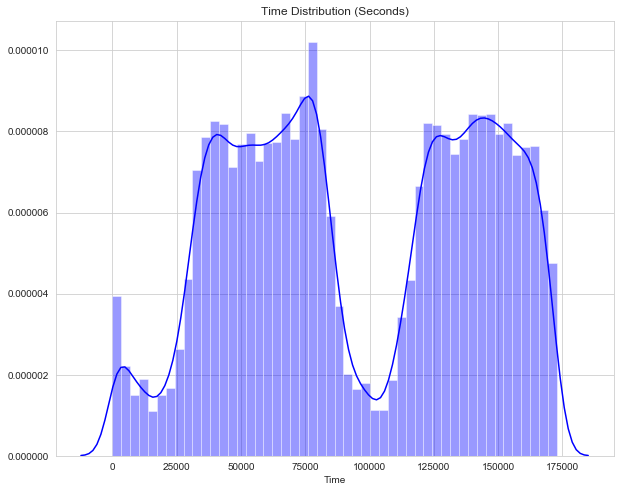

In [9]:
#plot the time feature
plt.figure(figsize=(10,8), )
plt.title('Time Distribution (Seconds)')

sns.distplot(data['Time'], color='blue');

In [10]:
# data.drop('Time', axis=1, inplace=True)

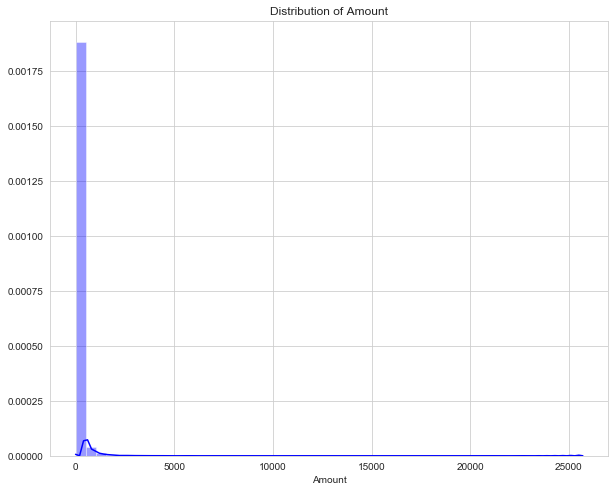

In [11]:
#plot the amount feature
plt.figure(figsize=(10,8))
plt.title('Distribution of Amount')
sns.distplot(data['Amount'],color='blue');

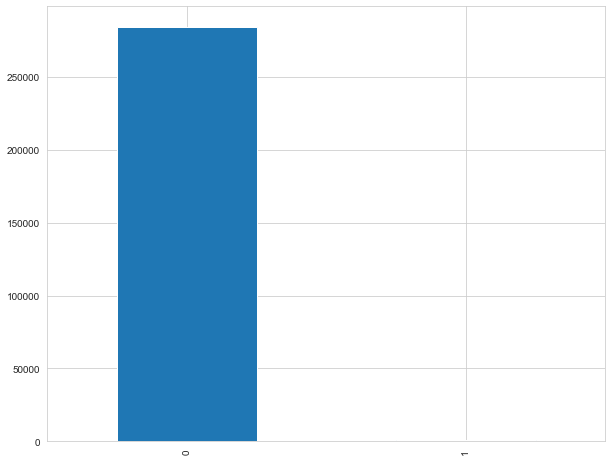

In [12]:
data.Class.value_counts().plot(kind='bar', figsize=(10,8))

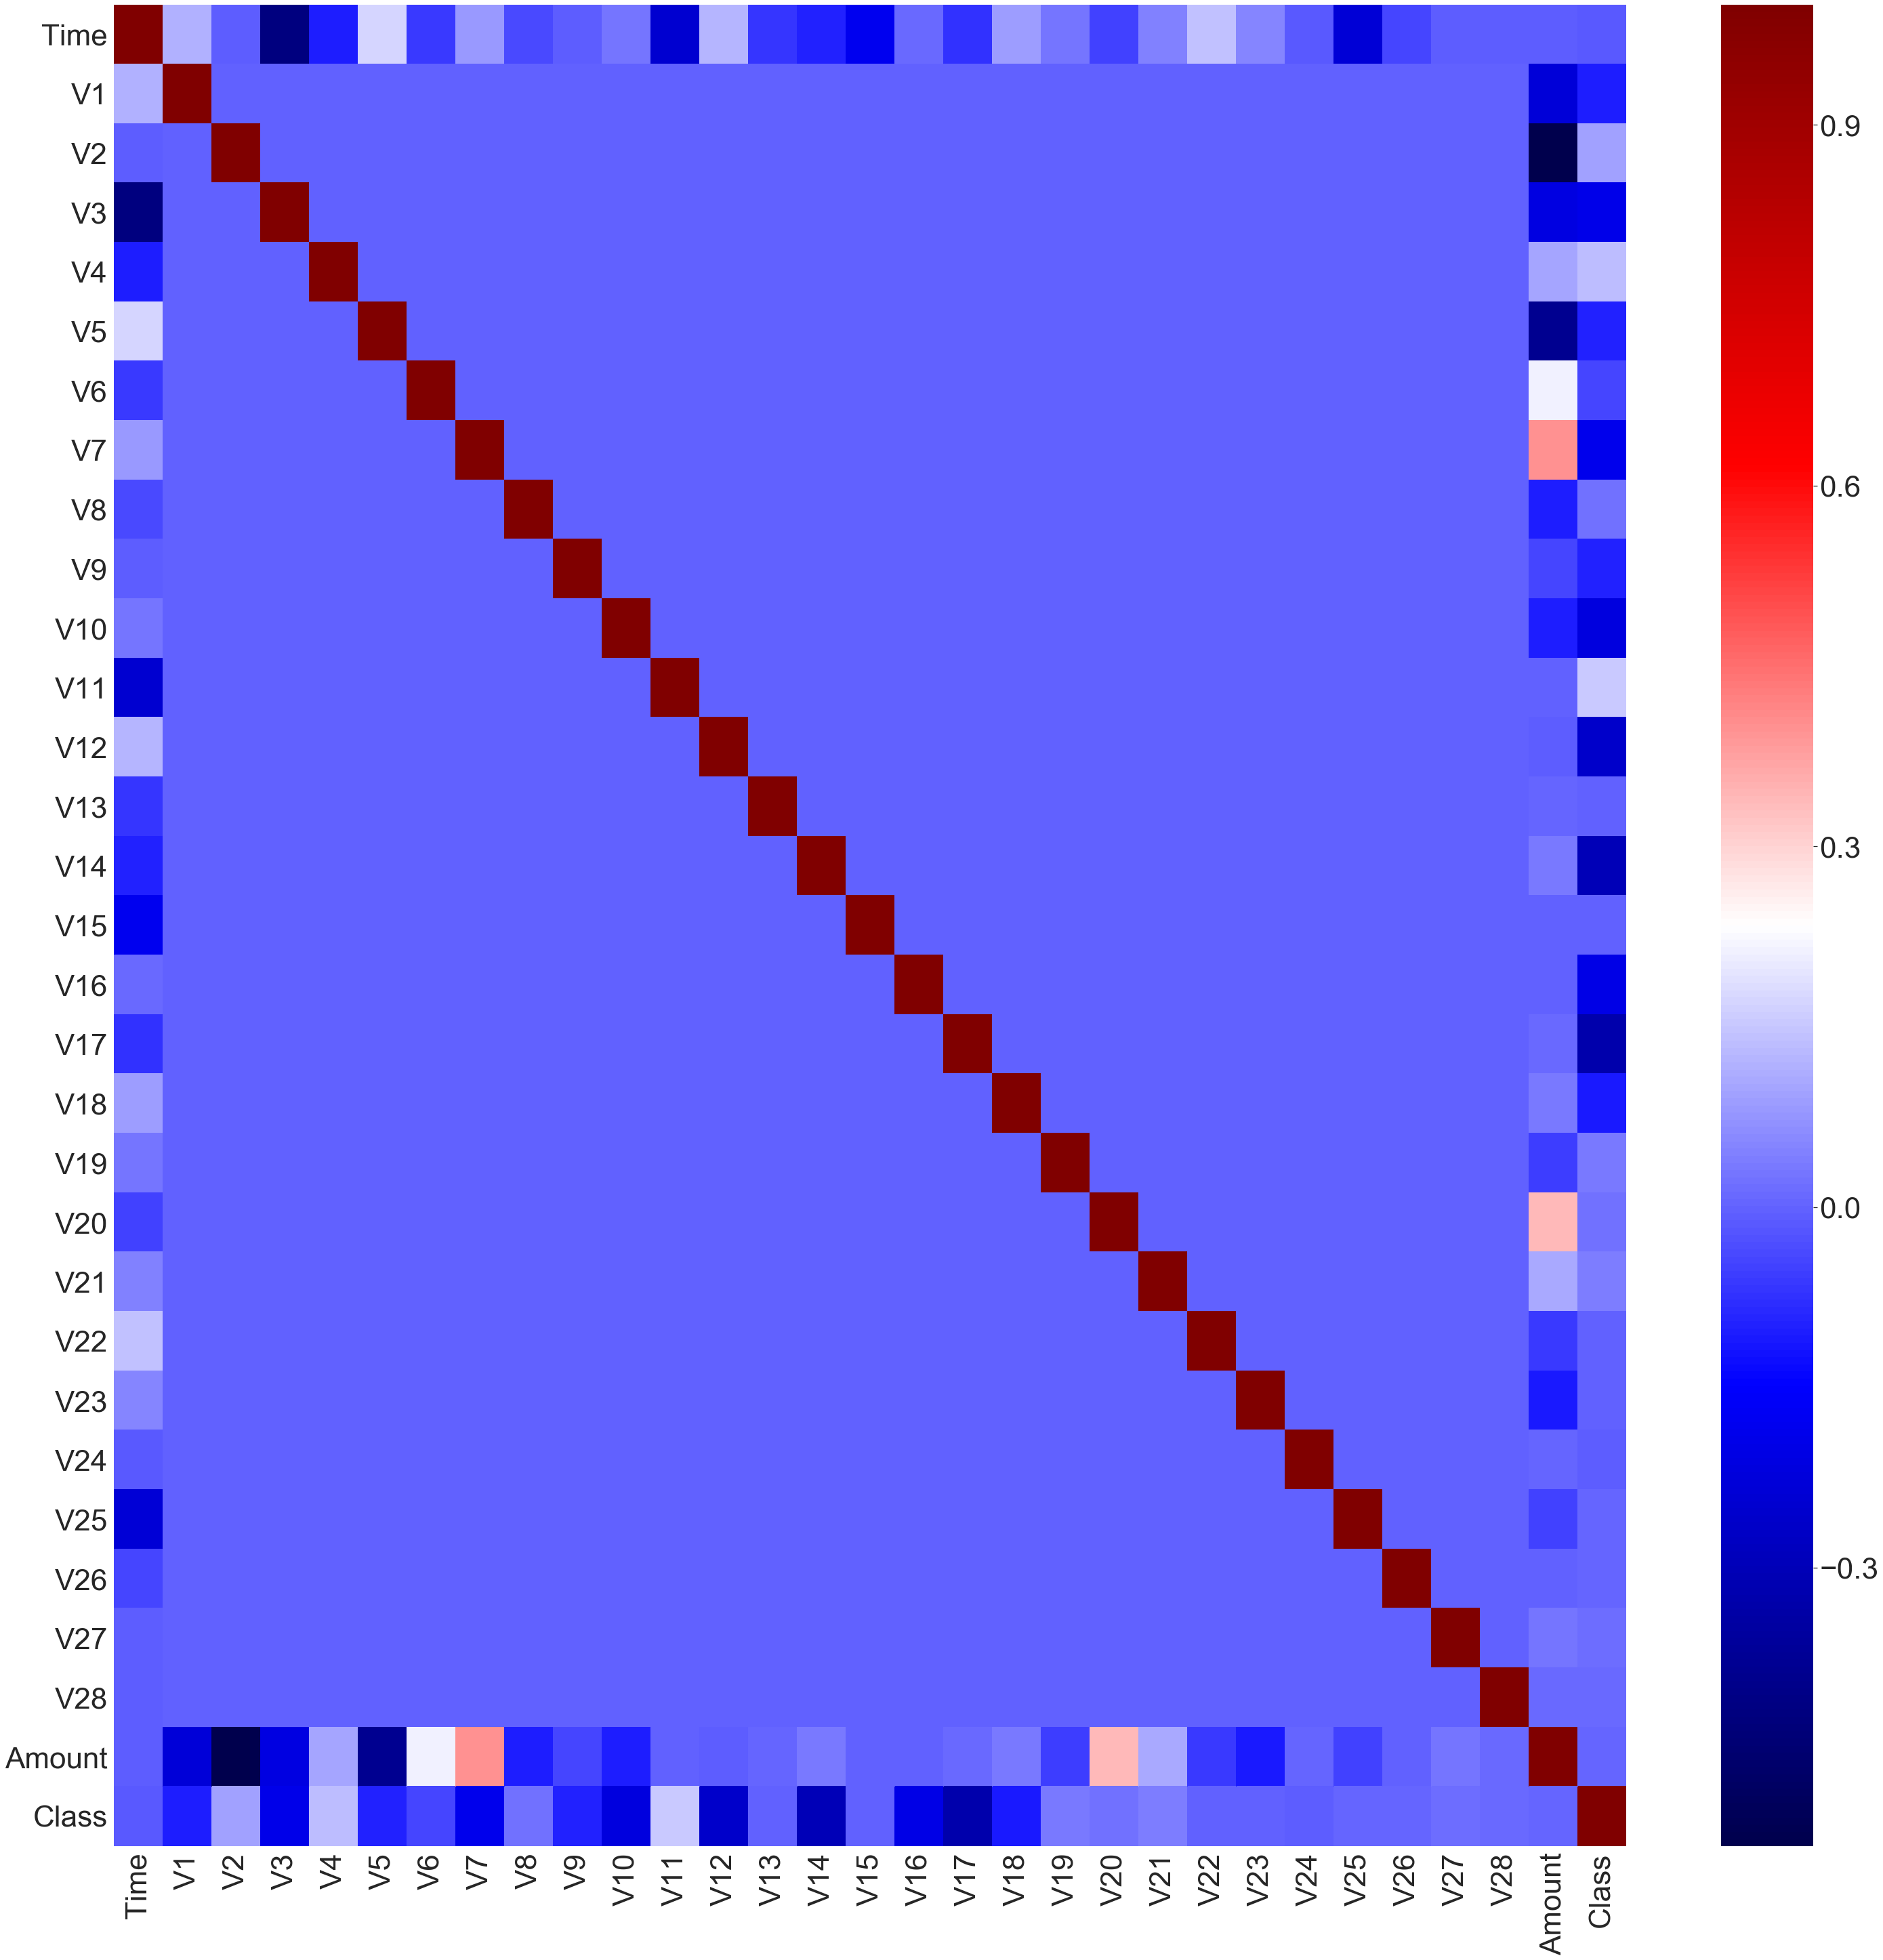

In [13]:
#heatmap to find any high correlations

plt.figure(figsize=(50,50))
sns.set(font_scale=4)
sns.heatmap(data=data.corr(), cmap="seismic")
plt.show();

# Highest correlations come from:
- Time & V3 (-0.42)
- Amount & V2 (-0.53)
- Amount & V4 (0.4)

While these correlations are high, I don't expect it to run the risk of multicollinearity.

In [14]:
X = data.drop('Class', axis=1)
y = data.Class

# Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

x_sc = StandardScaler()
# data["normalized_amt"] = x_sc.fit_transform(data.Amount.values.reshape(-1, 1))
X_std = x_sc.fit_transform(X)

penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
log_reg = LogisticRegression(solver='lbfgs', max_iter=10000)

logistic_grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train, y_train)

y_pred = logistic_grid.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[56855     9]
 [   41    57]]
0.9991222218320986


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [18]:
score = cross_val_score(log_reg, X_std, y, cv=10)
score

array([0.99866582, 0.99887648, 0.999684  , 0.99898178, 0.99884133,
       0.99912219, 0.99961376, 0.99908708, 0.99922753, 0.99901685])

# Deep Learning

In [19]:
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
# X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
#                                                             test_size=0.1, random_state=42)

In [21]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_validate.shape)
# print(y_validate.shape)

In [22]:
# print(X_test.shape)
# print(y_test.shape)

In [23]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# X_validate = np.array(X_validate)

In [24]:
y_train = np.array(y_train)
y_test = np.array(y_test)
# y_validate = np.array(y_validate)

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [29]:
model = Sequential([
    Dense(units=16, input_dim=30, activation="relu"),
    Dense(units=24, activation="relu"),  
    Dropout(0.5),  
    Dense(20, activation="relu"),  
    Dense(24, activation="relu"),  
    Dense(1, activation="sigmoid"),  
])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_7 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 25        
Total params: 1,933
Trainable params: 1,933
Non-trainable params: 0
____________________________________________________

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, epochs=10)

Epoch 1/10
227845/227845 [==============================] - 12s 51us/step - loss: 0.0104 - accuracy: 0.9985
Epoch 2/10
227845/227845 [==============================] - 10s 43us/step - loss: 0.0039 - accuracy: 0.9994
Epoch 3/10
227845/227845 [==============================] - 10s 44us/step - loss: 0.0033 - accuracy: 0.9994
Epoch 4/10
227845/227845 [==============================] - 11s 50us/step - loss: 0.0031 - accuracy: 0.9994
Epoch 5/10
227845/227845 [==============================] - 11s 50us/step - loss: 0.0030 - accuracy: 0.9994
Epoch 6/10
227845/227845 [==============================] - 11s 50us/step - loss: 0.0030 - accuracy: 0.9994
Epoch 7/10
227845/227845 [==============================] - 16s 70us/step - loss: 0.0027 - accuracy: 0.9994
Epoch 8/10
227845/227845 [==============================] - 13s 57us/step - loss: 0.0028 - accuracy: 0.9995
Epoch 9/10
227845/227845 [==============================] - 12s 53us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 10/10
227845/227845 [=

In [32]:
score = model.evaluate(X_test, y_test)

56962/56962 [==============================] - 2s 31us/step


In [33]:
print(score)

[0.003306819729414474, 0.9992977976799011]


In [34]:
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)

Each row: actual class

Each column: predicted class

First row: Non-fraudulent, the negative class:
* 56843 were correctly classified as Non-fraudulent. **True negatives**. 
* Remaining 21 were wrongly classified as fraud. **False positive**


Second row: The fraud transactions, the positive class:
* 19 were incorrectly classified as Non-fraudulent. **False negatives**
* 79 were correctly classified as Fraud. **True positives**

In [35]:
print(confusion_matrix(y_test, y_pred.round()))
print(accuracy_score(y_test, y_pred.round()))

[[56843    21]
 [   19    79]]
0.9992977774656788


## Accuracy, Recall, Precision, and F1 Score
For this section, I’ll be using these abbreviations in the formulas:
- **TP = True Positive**. Fraudulent transactions the model predicts as fraudulent.
- **TN = True Negative**. Normal transactions the model predicts as normal.
- **FP = False Positive**. Normal transactions the model predicts as fraudulent.
- **FN = False Negative**. Fraudulent transactions the model predicts as normal.
****
### Precision 
**`Precision:`** measures the accuracy of positive predictions. Also called the **`precision`** of the classifier
$$\textrm{precision} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Positives}}$$

## Recall

**`Precision`** is typically used with **`recall`** (**`Sensitivity`** or **`True Positive Rate`**). The ratio of positive instances that are correctly detected by the classifier.

$$\textrm{recall} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Negatives}}$$


## F1 Score

$F_1$ score is the harmonic mean of precision and recall. Regular mean gives equal weight to all values. Harmonic mean gives more weight to low values.


$$F_1=\frac{2}{\frac{1}{\textrm{precision}}+\frac{1}{\textrm{recall}}}=2\times \frac{\textrm{precision}\times \textrm{recall}}{\textrm{precision}+ \textrm{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

The $F_1$ score favours classifiers that have similar precision and recall.


In [36]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.81      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [52]:
print(f"Recall: {(79)/(79 + 19)}")
print(f"Precision: {(79)/(79 + 21)}")

Recall: 0.8061224489795918
Precision: 0.79


In [41]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    print(cm)
    sns.heatmap(cm, annot=True)
    sns.set(font_scale=1)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

[[56843    21]
 [   19    79]]


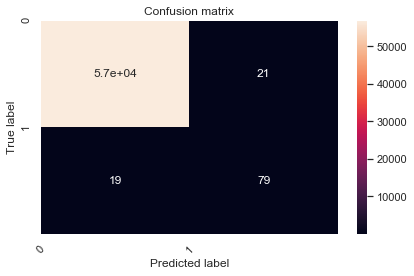

In [42]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred.round()), classes=[0,1])